In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Read csv as dataframe
msft = pd.read_csv('MSFT.csv')
# Convert Date column to datetime
msft['Date'] = pd.to_datetime(msft['Date'])
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-14,95.120003,95.410004,93.500000,93.849998,88.573227,32132000
1,2018-03-15,93.529999,94.580002,92.830002,94.180000,88.884705,27611000
2,2018-03-16,94.680000,95.379997,93.919998,94.599998,89.281075,49081300
3,2018-03-19,93.739998,93.900002,92.110001,92.889999,87.667221,33344100
4,2018-03-20,93.050003,93.769997,93.000000,93.129997,87.893738,23075200


[Text(0.5, 0, 'Timesteps in Days'), Text(0, 0.5, 'Price (USD)')]

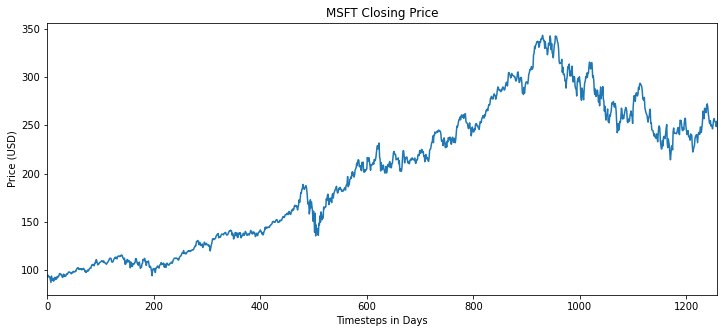

In [ ]:
title = 'MSFT Closing Price'
ylabel='Price (USD)'
xlabel='Timesteps in Days' 

ax = msft['Close'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# Set target series
series = msft['Close']
# Create train data set
train_split_date = '2022-03-14'
train_split_index = np.where(msft.Date == train_split_date)[0][0]
x_train = msft.loc[msft['Date'] <= train_split_date]['Close']
# Create test data set
test_split_date = '2022-09-14'
test_split_index = np.where(msft.Date == test_split_date)[0][0]
x_test = msft.loc[msft['Date'] >= test_split_date]['Close']
# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = msft.loc[(msft['Date'] < test_split_date) & (msft['Date'] > train_split_date)]['Close']

<AxesSubplot:title={'center':'MSFT Closing Price'}, xlabel='Timesteps in Days', ylabel='Price (USD)'>

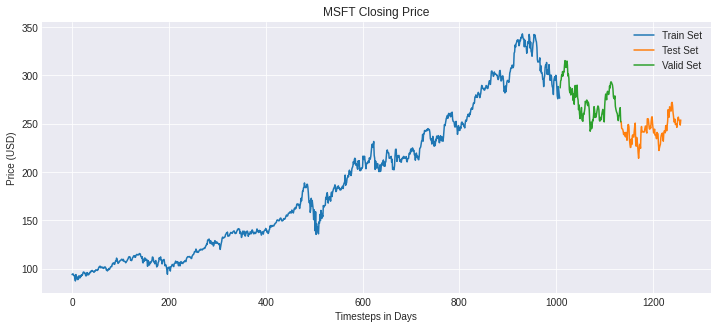

In [ ]:
title='MSFT Closing Price'
ylabel='Price (USD)'
xlabel='Timesteps in Days' 

x_train.plot(legend=True,label='Train Set',figsize=(12,5), title = title, xlabel=xlabel, ylabel=ylabel)
x_test.plot(legend=True,label='Test Set',figsize=(12,5))
x_valid.plot(legend=True,label='Valid Set',figsize=(12,5))


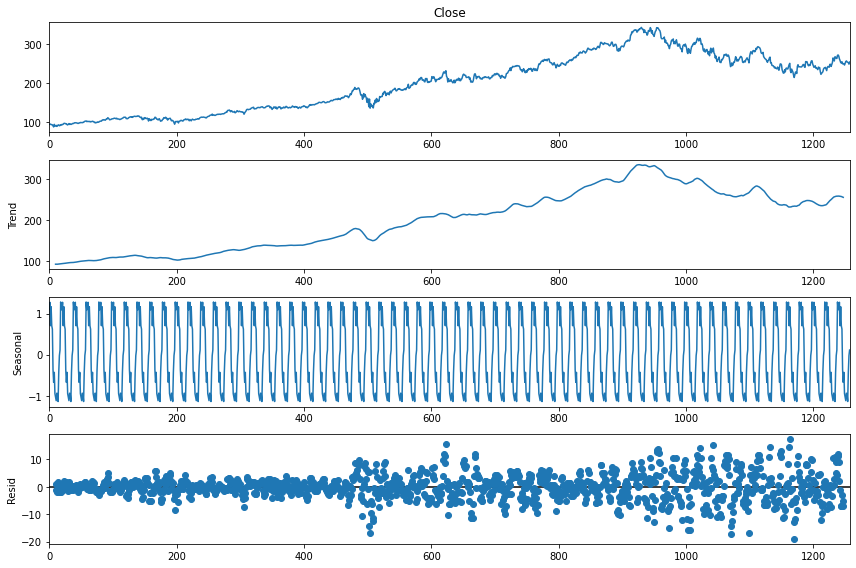

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt
decompose_result = seasonal_decompose(msft['Close'].dropna(), period = 20) 
df_trend = decompose_result.trend 
df_season = decompose_result.seasonal 
df_residual = decompose_result.resid
plt.rcParams['figure.figsize'] = (12, 8) 
fig = decompose_result.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [ ]:
def adf_test(timeseries, window=12, cutoff=0.05):
    """
    Pass in a time series, window of 12 days, cutoff confidence (p-value) of 0.05 and an optional title, returns an ADF report
    """
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #ADF Test function
    print(f'Augmented Dickey-Fuller Test: {title}')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20) 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No. of Lags Used','Number of Observations Used'])

    for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
    
    pvalue = dftest[1]

    if pvalue <= cutoff:
        print('p-value = %.4f' % pvalue)
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('p-value = %.4f' % pvalue)
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    
    print(dfoutput)

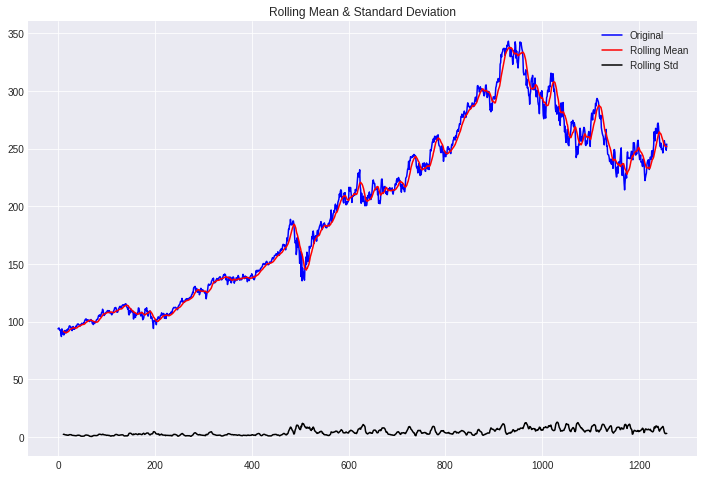

Augmented Dickey-Fuller Test: MSFT Closing Price
p-value = 0.5913
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Test Statistic                   -1.381025
p-value                           0.591339
No. of Lags Used                  9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


In [ ]:
adf_test(series)

In [ ]:
# Non-stationary series hence get the difference of each adjacent point of data in Close
msft_1st_order_diff = series.diff()

# Drop the first row as it will have a null value in this column
msft_1st_order_diff.dropna(inplace=True)

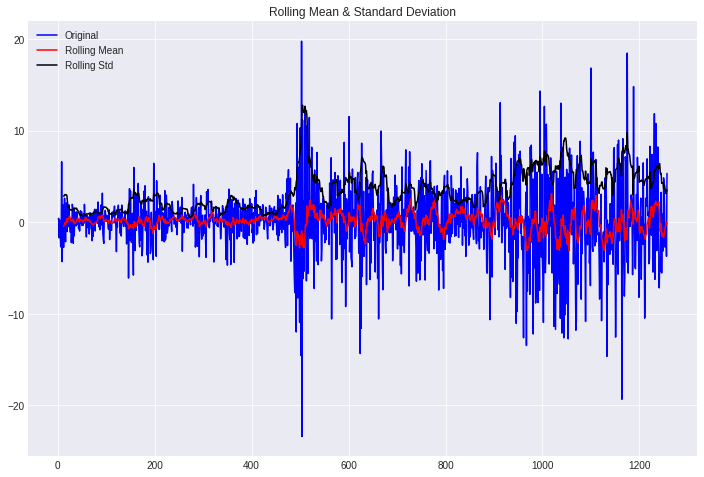

Augmented Dickey-Fuller Test: MSFT Closing Price
p-value = 0.0000
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Test Statistic                -1.177644e+01
p-value                        1.059695e-21
No. of Lags Used               8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


In [ ]:
adf_test(msft_1st_order_diff)

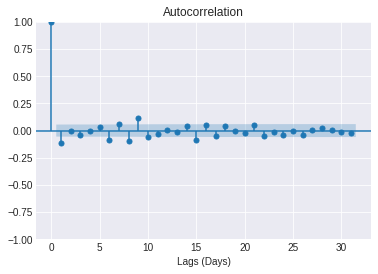

In [ ]:
#ACF Plot
plot_acf(msft_1st_order_diff)
plt.xlabel('Lags (Days)')
plt.show()

For ACF: If first lag +ve then AR component, if -ve then MA component. Since the first lag is -ve, and the 2nd lag is +ve; the 1st lag is used as a moving average point.

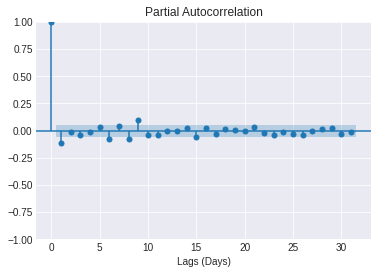

In [ ]:
#PACF plot
plot_pacf(msft_1st_order_diff)
plt.xlabel('Lags (Days)')
plt.show()

\For the PACF plot, since there is a substantial dropoff at lag one, which is negatively correlated, an AR factor of at least 1 will also be used.

In [ ]:
#Checking for best model
model = auto_arima(x_train,seasonal=False).summary()

In [ ]:
print(model)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1008
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2659.697
Date:                Tue, 14 Mar 2023   AIC                           5331.394
Time:                        19:38:48   BIC                           5360.882
Sample:                             0   HQIC                          5342.598
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6486      0.363      1.789      0.074      -0.062       1.359
ar.L1         -1.7135      0.035    -49.554      0.000      -1.781      -1.646
ar.L2         -0.8647      0.034    -25.202      0.0

In [ ]:
import statsmodels.api as sm

In [ ]:
# fit model
msft_arima = sm.tsa.arima.ARIMA(x_train, order=(2,1,2))
msft_arima_fitted = msft_arima.fit()
print(msft_arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2661.354
Date:                Tue, 14 Mar 2023   AIC                           5332.708
Time:                        19:32:34   BIC                           5357.282
Sample:                             0   HQIC                          5342.044
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7146      0.034    -49.833      0.000      -1.782      -1.647
ar.L2         -0.8658      0.034    -25.404      0.000      -0.933      -0.799
ma.L1          1.5947      0.043     36.868      0.0

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
#Create list of x train valuess
history = [x for x in x_train]

#establish list for predictions
model_predictions = []

#Count number of test data points
N_test_observations = len(x_test)

#Loop through every data point
for time_point in list(x_test.index):
    model = sm.tsa.arima.ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

RMSE_error = math.sqrt(MSE_error)
print('Testing Root Mean Squared Error is {}'.format(RMSE_error))

MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Absolute Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 35.65339553697968
Testing Root Mean Squared Error is 5.971046435674377
Testing Mean Absolute Error is 4.3938161264713536
Stored 'model_predictions' (list)


In [ ]:
mape = np.mean(np.abs(x_test - model_predictions)/np.abs(x_test))*100
print('Testing MAPE is {}'.format(mape) + '%')

Testing MAPE is 1.8106048029936674%


In [ ]:
#validate for performance accuracy using validation set
x_valid_mean = x_valid.rolling(3).mean().dropna()

SE_error = mean_squared_error(x_valid_mean, model_predictions)
print('Validating Mean Squared Error is {}'.format(MSE_error))

RMSE_error = math.sqrt(MSE_error)
print('Validating Root Mean Squared Error is {}'.format(RMSE_error))

MAE_error = mean_absolute_error(x_valid_mean, model_predictions)
print('Validating Mean Absolute Error is {}'.format(MAE_error))

Validating Mean Squared Error is 35.65339553697968
Validating Root Mean Squared Error is 5.971046435674377
Validating Mean Absolute Error is 30.66220024205789


In [ ]:
mape = np.mean(np.abs(x_valid_mean - model_predictions)/np.abs(x_valid_mean))*100
print('Validating MAPE is {}'.format(mape) + '%')

Validating MAPE is 10.90481940568126%


In [ ]:
"""
# %store model_predictions
%store -r model_predictions
# Check to see if it reloaded
model_predictions[:5]
# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')
"""

"\n# %store model_predictions\n%store -r model_predictions\n# Check to see if it reloaded\nmodel_predictions[:5]\n# Load model\nfrom statsmodels.tsa.arima.model import ARIMAResults\nloaded = ARIMAResults.load('arima_111.pkl')\n"

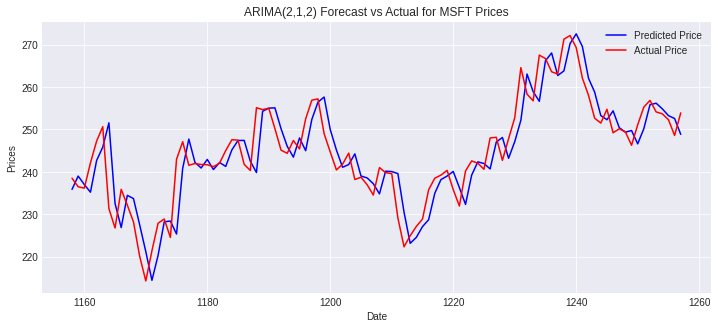

<Figure size 864x360 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.title('ARIMA(2,1,2) Forecast vs Actual for MSFT Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(12,5))
plt.show()

In [ ]:
print(model_predictions)
len(model_predictions)

[276.58207996093483, 255.54305404718792, 244.9276708988275, 243.8125991794984, 244.84521233447657, 242.92771877551596, 239.2605844497248, 240.39225812546763, 238.51357067739585, 237.43717454616305, 236.42240615203588, 240.31287819499204, 238.36438273105867, 233.4734269835677, 239.04593297675115, 248.06610659812586, 249.75586126480604, 247.40976522795637, 235.20132278224958, 229.21549560733067, 225.73302862479645, 225.6555141680791, 233.2475059381915, 229.86710656938925, 235.85459282378247, 239.00260555897594, 237.00757776585928, 235.2006391938502, 242.6682091091511, 245.84402881898274, 251.57009132721518, 232.533094558836, 226.84657609494897, 234.45618198382496, 233.68971795890798, 227.51434149711602, 221.1822441642048, 214.39734704116248, 220.30132278462708, 228.2107439942018, 228.3861363690929, 225.32204902574523, 240.82511769119338, 247.7298325303021, 242.2153082523327, 240.91615586279994, 242.93031599727712, 240.54503892095033, 242.20346574445247, 241.28636399089427, 245.1894853132

124